In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
import joblib


## connecting to the database

In [5]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

In [7]:
import psycopg2
hostname = 'localhost'
database = 'nyfd'
user_name = 'postgres'
pwd = 'raksha' 
port_id= 5432
conn=None
cur=None

In [9]:
engine = create_engine(f'postgresql://{user_name}:{pwd}@{hostname}:{port_id}/{database}')

In [11]:
sql = 'SELECT * FROM public."f_eng_selected"'

In [13]:
model_tr = pd.read_sql_query(sql,engine)

In [15]:
model_tr.sample(5)

,facility,critical_violation,avg_days_bw_inspection,violation_item,total_critical_violations,total_crit_not_corrected,total_noncritical_violations,permit_status,inspection_frequency,risk_of_food_borne_illness
1143770,SYRACUSE UNIVERSITY HOTEL & CONF CTR,Not Critical Violation,49.250000,10B,2.0,0.0,11.0,Active,0.020420,Medium
269430,CONGREGATION BNAI YOEL BOYS SCHOOL,Not Critical Violation,24.008696,14A,1.0,0.0,6.0,Active,0.041825,Medium
577282,IRON CAFÉ,Not Critical Violation,124.673469,8C,0.0,0.0,2.0,Active,0.008183,Low
413352,FARM FAMILY INSURANCE,Not Critical Violation,178.142857,8D,0.0,0.0,2.0,Active,0.005702,Low
219986,CHEF WANG,Not Critical Violation,20.928571,8A,0.0,0.0,1.0,Active,0.048188,Low


In [17]:
def mdl(data):
    return data
mld = mdl(model_tr)

In [19]:
mld.columns

Index(['facility', 'critical_violation', 'avg_days_bw_inspection',
       'violation_item', 'total_critical_violations',
       'total_crit_not_corrected', 'total_noncritical_violations',
       'permit_status', 'inspection_frequency', 'risk_of_food_borne_illness'],
      dtype='object')

In [21]:
mld.dtypes

facility                         object
critical_violation               object
avg_days_bw_inspection          float64
violation_item                   object
total_critical_violations       float64
total_crit_not_corrected        float64
total_noncritical_violations    float64
permit_status                    object
inspection_frequency            float64
risk_of_food_borne_illness       object
dtype: object

In [23]:
X = mld.drop(columns=['risk_of_food_borne_illness','facility','critical_violation'])
y = mld['critical_violation'].copy()

In [25]:
from sklearn.model_selection import train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(828124, 7) (828124,)
(207032, 7) (207032,)
(258790, 7) (258790,)


In [27]:
train_df = pd.concat([X_train,y_train],axis=1)
train_df

,avg_days_bw_inspection,violation_item,total_critical_violations,total_crit_not_corrected,total_noncritical_violations,permit_status,inspection_frequency,critical_violation
732792,153.166667,Nan,0.81277,0.02875,5.250886,Active,0.006637,Not Critical Violation
395735,56.134921,10B,0.00000,0.00000,4.000000,Active,0.017953,Not Critical Violation
302987,81.337079,8A,2.00000,0.00000,6.000000,Active,0.012431,Not Critical Violation
262520,63.319527,15A,1.00000,0.00000,5.000000,Active,0.015885,Not Critical Violation
452750,22.973510,10A,1.00000,0.00000,16.000000,Active,0.043804,Not Critical Violation
...,...,...,...,...,...,...,...,...
972935,383.260870,11C,0.00000,0.00000,3.000000,Expired,0.002722,Not Critical Violation
624837,34.088000,15A,0.00000,0.00000,3.000000,Active,0.023935,Not Critical Violation
981215,221.809524,11D,0.00000,0.00000,7.000000,Active,0.004722,Not Critical Violation
1236327,110.888889,2E,1.00000,0.00000,5.000000,Active,0.009184,Critical Violation


In [29]:
val_df = pd.concat([X_val,y_val],axis=1)
test_df = pd.concat([X_test,y_test],axis=1)

In [31]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 828124 entries, 732792 to 369183
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   avg_days_bw_inspection        828124 non-null  float64
 1   violation_item                828124 non-null  object 
 2   total_critical_violations     828124 non-null  float64
 3   total_crit_not_corrected      828124 non-null  float64
 4   total_noncritical_violations  828124 non-null  float64
 5   permit_status                 828124 non-null  object 
 6   inspection_frequency          828124 non-null  float64
dtypes: float64(5), object(2)
memory usage: 50.5+ MB


## DATA PREPROCESSING

In [33]:
X_train.columns

Index(['avg_days_bw_inspection', 'violation_item', 'total_critical_violations',
       'total_crit_not_corrected', 'total_noncritical_violations',
       'permit_status', 'inspection_frequency'],
      dtype='object')

In [35]:
cat_cols = ['violation_item','permit_status']
num_cols = ['avg_days_bw_inspection','total_critical_violations','total_crit_not_corrected','total_noncritical_violations','inspection_frequency']

In [37]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
num_transformer = Pipeline(steps=[
	("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

In [93]:
from sklearn.preprocessing import LabelEncoder
class LabelEncoderTransformer:
    def __init__(self):
        self.le = LabelEncoder()

    def fit(self, X, y=None):
        self.le.fit(X)
        return self

    def transform(self, X):
        return self.le.transform(X)

target_pipe = Pipeline([
    ('label_encoder', LabelEncoderTransformer())
])
y_test_en = target_pipe.fit_transform(y_test)

In [95]:
y_test_en

array([1, 0, 1, ..., 1, 1, 0])

In [41]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
	("num", num_transformer, num_cols),
	("cat", cat_transformer, cat_cols)
])


In [43]:
pr = preprocessor.fit_transform(X_train)
pr

array([[ 5.15711851e-01, -3.42620167e-03, -4.01190647e-04, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-4.68174471e-01, -5.85540871e-01, -9.55726886e-02, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-2.12628636e-01,  8.46879903e-01, -9.55726886e-02, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.21173940e+00, -5.85540871e-01, -9.55726886e-02, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 8.70219740e-02,  1.30669516e-01, -9.55726886e-02, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-7.87604173e-01, -5.85540871e-01, -9.55726886e-02, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

## PCA [DIMENSIONALITY REDUCTION]

In [53]:
from sklearn.decomposition import PCA
pca_pipeline= Pipeline(
    steps=[
        ('pca', PCA(n_components=0.95))
    ]
)
pca_features = pca_pipeline.fit_transform(pr)
feature_names = pca_pipeline.named_steps['pca'].get_feature_names_out()

In [63]:
num_components = pca_pipeline.named_steps['pca'].n_components_
print(num_components)

18


In [69]:
pca_df = pd.DataFrame(pca_features, columns=feature_names)
pca_df

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17
0,-0.377756,0.267510,0.064101,0.428289,0.133470,-0.233340,0.739503,0.044502,0.060712,-0.002498,-0.020841,0.031629,0.024354,0.006311,0.012878,0.001979,0.006234,0.000823
1,-0.260053,-0.299416,-0.139233,-0.691289,0.010714,-0.237665,-0.163333,-0.135580,-0.352631,-0.703809,-0.440417,0.232381,0.107582,0.003115,0.026469,0.012983,0.014834,0.008165
2,0.659600,0.088393,-0.177663,0.337638,-0.464113,-0.228687,-0.244804,-0.471079,0.765714,0.001628,-0.103907,0.125003,0.078337,0.001802,0.028572,0.013318,0.013903,0.007850
3,0.225489,-0.127705,-0.169217,-0.226383,-0.234216,-0.233828,-0.275750,0.844095,0.269542,0.001148,-0.070994,0.091078,0.057917,0.001412,0.020348,0.010353,0.010517,0.006328
4,1.776182,-0.383109,-0.633161,-0.073734,1.247176,-0.256928,0.158218,-0.035891,-0.046425,-0.008094,0.057343,-0.131944,-0.153704,-0.005596,-0.144299,-0.131971,-0.270278,-0.492032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828119,-2.002349,0.776334,0.400459,1.597556,0.855752,1.340083,-0.508403,-0.072114,-0.108493,0.002672,0.075870,-0.173728,-0.222209,-0.049387,-0.495285,0.752566,0.258502,0.068711
828120,-0.271512,-0.376088,-0.126883,-0.895543,-0.198888,-0.253918,-0.267770,0.834593,0.263429,0.001893,-0.065394,0.078241,0.046767,0.002441,0.014186,0.009164,0.008396,0.004998
828121,-0.725150,0.240119,-0.007712,0.614274,0.972720,-0.154087,-0.334949,-0.141444,-0.361179,0.707173,-0.428058,0.226708,0.109690,-0.005660,0.021184,0.005916,0.013253,0.010218
828122,-0.015085,0.052713,-0.091210,0.143764,-0.111719,-0.215238,-0.158896,-0.034133,-0.065296,-0.001119,0.037906,-0.070287,-0.070298,-0.011795,-0.038412,-0.018107,-0.029654,-0.010200


In [73]:
train_df

,avg_days_bw_inspection,violation_item,total_critical_violations,total_crit_not_corrected,total_noncritical_violations,permit_status,inspection_frequency,critical_violation
732792,153.166667,Nan,0.81277,0.02875,5.250886,Active,0.006637,Not Critical Violation
395735,56.134921,10B,0.00000,0.00000,4.000000,Active,0.017953,Not Critical Violation
302987,81.337079,8A,2.00000,0.00000,6.000000,Active,0.012431,Not Critical Violation
262520,63.319527,15A,1.00000,0.00000,5.000000,Active,0.015885,Not Critical Violation
452750,22.973510,10A,1.00000,0.00000,16.000000,Active,0.043804,Not Critical Violation
...,...,...,...,...,...,...,...,...
972935,383.260870,11C,0.00000,0.00000,3.000000,Expired,0.002722,Not Critical Violation
624837,34.088000,15A,0.00000,0.00000,3.000000,Active,0.023935,Not Critical Violation
981215,221.809524,11D,0.00000,0.00000,7.000000,Active,0.004722,Not Critical Violation
1236327,110.888889,2E,1.00000,0.00000,5.000000,Active,0.009184,Critical Violation


## MODEL SELECTION

In [75]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
from catboost import CatBoostClassifier

In [77]:
from sklearn.preprocessing import LabelEncoder

def split_data(data):
    X = data.drop(columns=["critical_violation"])
    y = data.critical_violation.copy()
    le = LabelEncoder()
    y = le.fit_transform(y)
    return (X, y)
data = pd.concat([train_df, val_df], axis=0)
X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(1035156, 7) (1035156,)


In [79]:
algorithms = {
    'CAT MODEL': CatBoostClassifier(),
    'XGBOOST CLASSIFIER': XGBClassifier(),
    'LGB': lgb.LGBMClassifier(),
    'logistic regression': LogisticRegression(),
    'random_forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [81]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [87]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
        ("pca",pca_pipeline),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="accuracy",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="accuracy", title=name)

	ax.legend(loc="lower right")

	plt.show()

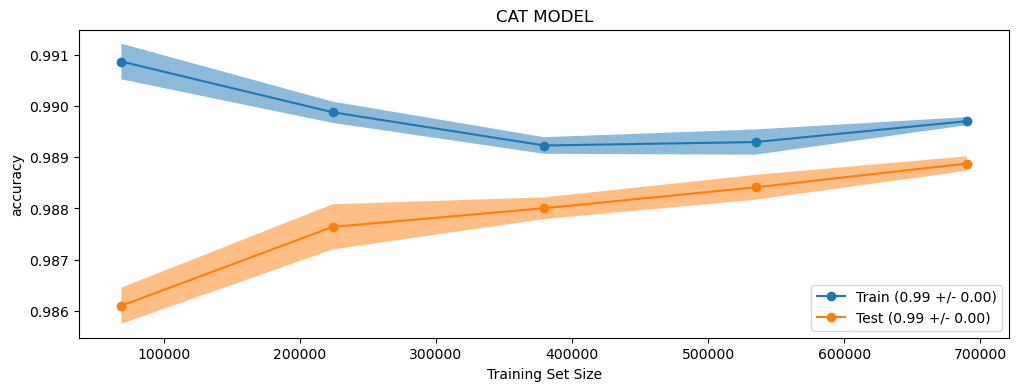

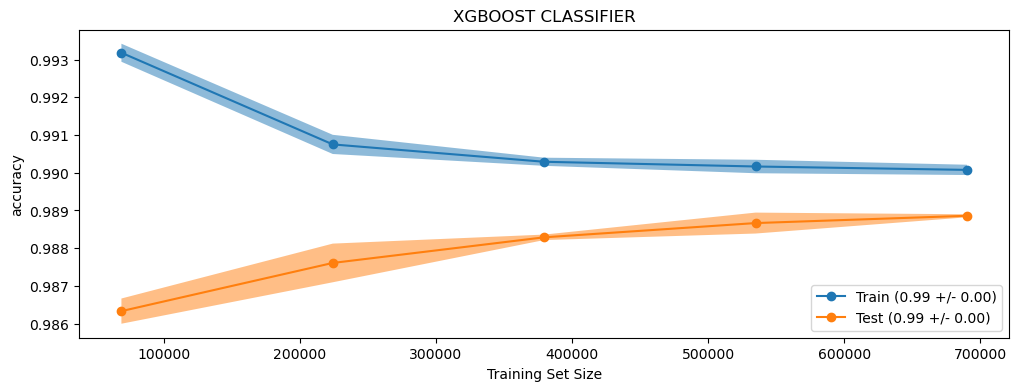

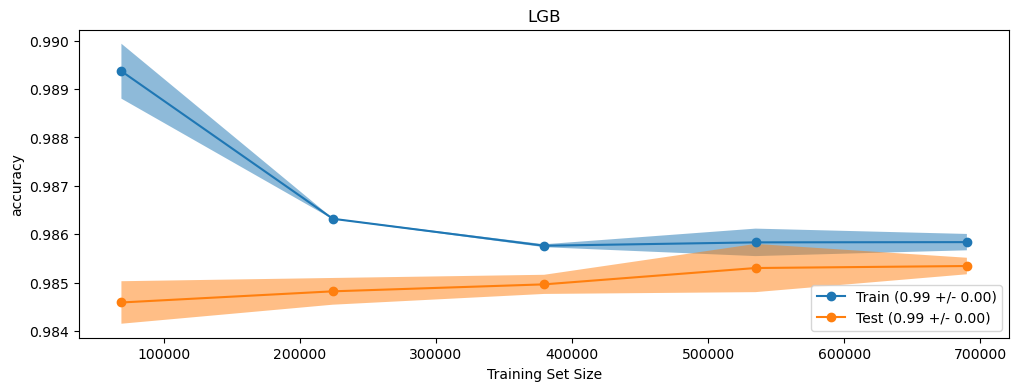

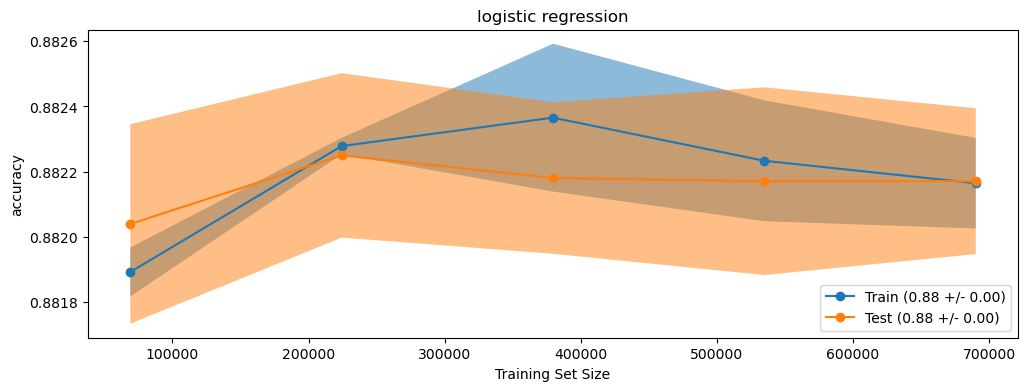

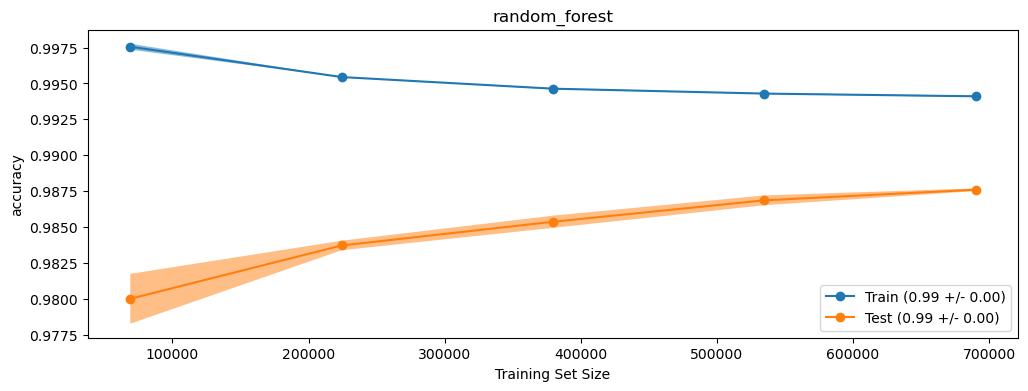

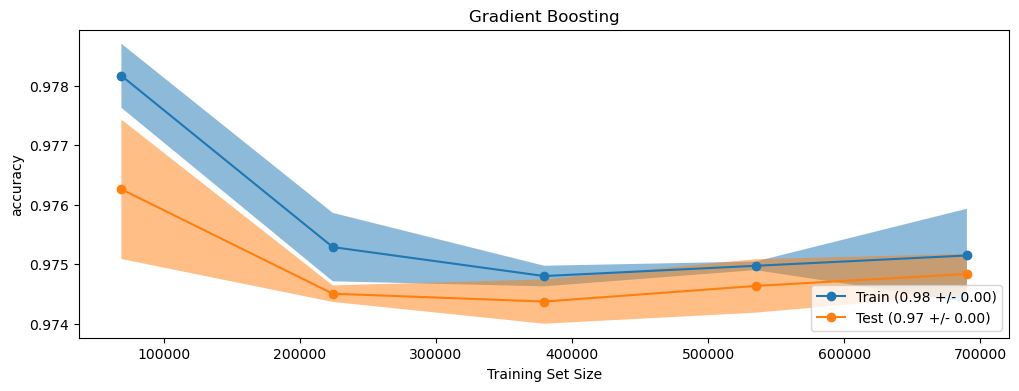

In [89]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

## MODEL EVALUATION

- WE CAN FINALIZE `XGBOOST CLASSIFIER`

## FINAL MODEL

In [113]:
model = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('PCA',pca_pipeline),
    ('XGBOOST', XGBClassifier(reg_alpha=0.1,reg_lambda=0.1,)) 
]) 

In [115]:
model.fit(X_data,y_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['avg_days_bw_inspection',
                                                   'total_critical_violations',
                                                   'total_crit_not_corrected',
                                                   'total_noncritical_violations',
                                                   'inspection_frequency']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

## MODEL PERSISTENCE

In [117]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [119]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['avg_days_bw_inspection',
                                                   'total_critical_violations',
                                                   'total_crit_not_corrected',
                                                   'total_noncritical_violations',
                                                   'inspection_frequency']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [125]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_pred = saved_model.predict(X_test)
classification_report(y_test_en, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.97      0.94      0.95     30396\n           1       0.99      1.00      0.99    228394\n\n    accuracy                           0.99    258790\n   macro avg       0.98      0.97      0.97    258790\nweighted avg       0.99      0.99      0.99    258790\n'

+--------+------------+--------+----------+----------+
| Class  | Precision | Recall | F1-score | Support  |
+--------+------------+--------+----------+----------+
| 0      | 0.97      | 0.94   | 0.95     | 30,396   |
| 1      | 0.99      | 1.00   | 0.99     | 228,394  |
+--------+------------+--------+----------+----------+

Accuracy: 0.99

In [127]:
confusion_matrix(y_test_en,y_pred)

array([[ 28672,   1724],
       [  1029, 227365]], dtype=int64)